In [8]:
import os
import tempfile

from math import sqrt
import numpy as np
import scipy as sp
from scipy.integrate import solve_ivp
import matplotlib.pyplot as plt
#%matplotlib widget
#from itables import init_notebook_mode
#init_notebook_mode(all_interactive=True)

from sklearn.model_selection import train_test_split
import torch
#from ray import train, tune

In [9]:
import time

# Dumped Harmonic Oscillator, compare model 
In this notebook we will compare the performance of the varius models on the dumped harmonic oscillator dataset. 

## Load data

In [10]:
# import data
# data are generated by "src/DHOscillator_data_gen.py"
data = np.load('../data/DHOscillator_data.npy')
X = data[:,0]
Y = data[:,1:]

In [11]:
def data_loader(X, Y, batch_size):
    """
    Function to load data and divide it in batches
    input: X, Y, batch_size
    output: train_X_batches, train_Y_batches, val_X, val_Y, test_X, test_Y
    """

    # divide in train, validation and test
    train_frac = 0.7
    val_frac = 0.15
    test_frac = 0.15

    train_val_X = X[:int((train_frac+val_frac)*len(X))]
    train_val_Y = Y[:int((train_frac+val_frac)*len(X)), :]
    train_X, val_X, train_Y, val_Y = train_test_split(
        train_val_X, 
        train_val_Y, 
        test_size=val_frac/(train_frac+val_frac), 
        random_state=42
        )

    test_X = X[int((train_frac+val_frac)*len(X)):]
    test_Y = Y[int((train_frac+val_frac)*len(X)):, :]

    # convert to torch tensor
    train_X = torch.tensor(train_X, dtype=torch.float32).view(-1, 1)
    train_Y = torch.tensor(train_Y, dtype=torch.float32)
    val_X = torch.tensor(val_X, dtype=torch.float32).view(-1, 1)
    val_Y = torch.tensor(val_Y, dtype=torch.float32)
    test_X = torch.tensor(test_X, dtype=torch.float32).view(-1, 1)
    test_Y = torch.tensor(test_Y, dtype=torch.float32)

    # divide in batches train
    train_X_batches = torch.split(train_X, batch_size)
    train_Y_batches = torch.split(train_Y, batch_size)

    
    return train_X_batches, train_Y_batches, val_X, val_Y, test_X, test_Y

In [12]:
# use the data loader to get the data, in this example we use only one batch
train_X_batches, train_Y_batches, val_X, val_Y, test_X, test_Y = data_loader(X, Y, 595)

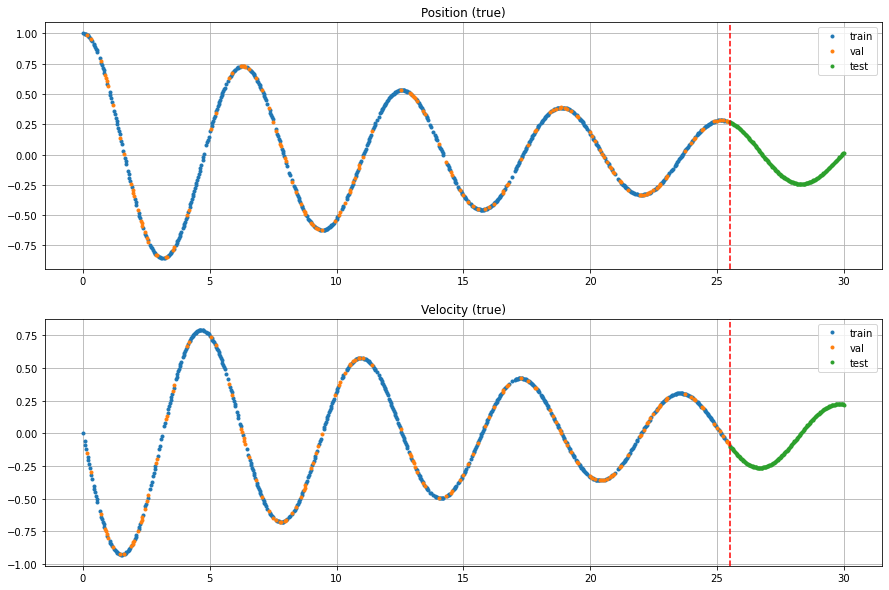

In [13]:
# plot the position 
plt.figure(figsize=(15, 10))
plt.subplot(2, 1, 1)
plt.plot(train_X_batches[0].detach().numpy(), train_Y_batches[0][:, 0].detach().numpy(), '.', label='train')
plt.plot(val_X.detach().numpy(), val_Y[:, 0].detach().numpy(), '.', label='val')
plt.plot(test_X.detach().numpy(), test_Y[:, 0].detach().numpy(), '.', label='test')
plt.grid()
plt.title('Position (true)')
plt.axvline(x=30*0.85, color='r', linestyle='--')
plt.legend()

# plot the velocity
plt.subplot(2, 1, 2)
plt.plot(train_X_batches[0].detach().numpy(), train_Y_batches[0][:, 1].detach().numpy(), '.', label='train')
plt.plot(val_X.detach().numpy(), val_Y[:, 1].detach().numpy(), '.', label='val')
plt.plot(test_X.detach().numpy(), test_Y[:, 1].detach().numpy(), '.', label='test')
plt.grid()
plt.title('Velocity (true)')
plt.axvline(x=30*0.85, color='r', linestyle='--')
plt.legend()


## Define some analysis functions

In [14]:
def plot_results(model, train_X_batches, train_Y_batches, val_X, val_Y, test_X, test_Y, save=False, name='model'):
    """
    Function to plot the results of the net for the
    position and velocity of the DHOscillator

    input: model, train_X_batches, train_Y_batches, val_X, val_Y, test_X, test_Y
    output: plot of the results
    """

    # get predictions
    Y_pred_train = model(train_X_batches[0])
    Y_pred_val = model(val_X)
    Y_pred_test = model(test_X)

    # plot the position, and subplot the residue
    plt.figure(figsize=(18, 13))
    plt.subplot(2, 2, 1)

    marker='.'
    markersize=2

    plt.plot(train_X_batches[0].detach().numpy(), train_Y_batches[0][:, 0].detach().numpy(), marker, label='train true', markersize=markersize)
    plt.plot(test_X.detach().numpy(), test_Y[:, 0].detach().numpy(), marker, label='test true', markersize=markersize)
    plt.plot(train_X_batches[0].detach().numpy(), Y_pred_train[:, 0].detach().numpy(), marker, label='train pred', markersize=markersize)
    plt.plot(test_X.detach().numpy(), Y_pred_test[:, 0].detach().numpy(), marker, label='test pred', markersize=markersize)
    plt.grid()

    plt.title('Position (true and %s prediction)' % name)
    plt.axvline(x=30*0.85, color='r', linestyle='--')
    plt.legend()

    plt.subplot(2, 2, 3)
    plt.plot(train_X_batches[0].detach().numpy(), train_Y_batches[0][:, 0].detach().numpy()-Y_pred_train[:, 0].detach().numpy(), marker, label='train', markersize=markersize)
    plt.plot(test_X.detach().numpy(), test_Y[:, 0].detach().numpy()-Y_pred_test[:, 0].detach().numpy(), marker, label='test', markersize=markersize)
    plt.grid()
    plt.ylabel('residue (true - pred)')
    plt.xlabel('time')
    plt.legend()
    plt.axvline(x=30*0.85, color='r', linestyle='--')


    # new figure for the velocity
    plt.subplot(2, 2, 2)

    plt.plot(train_X_batches[0].detach().numpy(), train_Y_batches[0][:, 1].detach().numpy(), marker, label='train true', markersize=markersize)
    plt.plot(test_X.detach().numpy(), test_Y[:, 1].detach().numpy(), marker, label='test true', markersize=markersize)
    plt.plot(train_X_batches[0].detach().numpy(), Y_pred_train[:, 1].detach().numpy(), marker, label='train pred', markersize=markersize)
    plt.plot(test_X.detach().numpy(), Y_pred_test[:, 1].detach().numpy(), marker, label='test pred', markersize=markersize)
    plt.grid()

    plt.title('Velocity (true and %s prediction)' % name)
    plt.axvline(x=30*0.85, color='r', linestyle='--')
    plt.legend()

    plt.subplot(2, 2, 4)
    plt.plot(train_X_batches[0].detach().numpy(), train_Y_batches[0][:, 1].detach().numpy()-Y_pred_train[:, 1].detach().numpy(), marker, label='train', markersize=markersize)
    plt.plot(test_X.detach().numpy(), test_Y[:, 1].detach().numpy()-Y_pred_test[:, 1].detach().numpy(), marker, label='test', markersize=markersize)
    plt.grid()
    plt.ylabel('residue (true - pred)')
    plt.xlabel('time')
    plt.legend()
    plt.axvline(x=30*0.85, color='r', linestyle='--')
    
    if save:
        # save the figure
        plt.savefig('../plot/DHOscillator_%s_results.png' % name)

In [15]:
def get_losses(model, train_X_batches, train_Y_batches, val_X, val_Y, test_X, test_Y):
    """
    Function to get the losses of the model for the train, validation and test set
    input: model, train_X_batches, train_Y_batches, val_X, val_Y, test_X, test_Y
    output: train_loss, val_loss, test_loss
    """

    # get predictions
    Y_pred_train = model(train_X_batches[0])
    Y_pred_val = model(val_X)
    Y_pred_test = model(test_X)

    # get losses, to numpy
    train_loss = torch.mean((Y_pred_train - train_Y_batches[0])**2)
    val_loss = torch.mean((Y_pred_val - val_Y)**2)
    test_loss = torch.mean((Y_pred_test - test_Y)**2)

    # print losses
    print('Train loss:', train_loss.item())
    print('Validation loss:', val_loss.item())
    print('Test loss:', test_loss.item())

    return train_loss.item(), val_loss.item(), test_loss.item() 

In [16]:
# def a function that get the time for one prediction sampling 10 time the test set, not with cuda
def get_pred_time(model, test_X, n_samples=1000):
    """
    Function to get the time for one prediction
    input: model, test_X, n_samples
    output: time
    """

    # get the time for one prediction
    times = []
    for i in range(n_samples):
        start = time.time()
        Y_pred_test = model(test_X)
        end = time.time()
        times.append((end - start)/len(test_X))

    time_pred = np.mean(times)
    time_pred_std = np.std(times)

    print('Time for one prediction:', time_pred, '+/-', time_pred_std)

    return time_pred, time_pred_std
    

In [17]:
# Model class
class FFNN(torch.nn.Module):
    def __init__(self, n_layers, n_neurons):
        super(FFNN, self).__init__()
        layers = []
        for i in range(n_layers):
            if i == 0:
                layers.append(torch.nn.Linear(1, n_neurons))
            else:
                layers.append(torch.nn.Linear(n_neurons, n_neurons))
            layers.append(torch.nn.Tanh())
        layers.append(torch.nn.Linear(n_neurons, 2))
        self.model = torch.nn.Sequential(*layers)
    def forward(self, x):
        return self.model(x)

In [18]:
def objective(config):
    net = FFNN(config["n_layers"], config["n_neurons"])

    device = "cpu"

    criterion = torch.nn.MSELoss()
    optimizer = torch.optim.Adam(net.parameters(), lr=config["lr"])
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
        optimizer, 
        'min', 
        factor=config["factor"], 
        patience=config["patience"]
    )

    train_X_batches, train_Y_batches, val_X, val_Y, test_X, test_Y = data_loader(data_X, data_Y, config["batch_size"], config["grid_num"])

    for epoch in range(50000):
        for i, (X, Y) in enumerate(zip(train_X_batches, train_Y_batches)):
            optimizer.zero_grad()
            X.requires_grad = True
            Y_pred = net(X)

            # get the derivatives
            dx_dt = torch.autograd.grad(Y_pred[:,0], X, grad_outputs=torch.ones_like(Y_pred[:,0]), create_graph=True)[0]
            dv_dt = torch.autograd.grad(Y_pred[:,1], X, grad_outputs=torch.ones_like(Y_pred[:,1]), create_graph=True)[0]

            # loss_ode and loss_ic 
            loss_ode = torch.mean((dx_dt[:,0] - Y_pred[:,1])**2 + (dv_dt[:,0] + 0.1*Y_pred[:,1] + Y_pred[:,0])**2)
            loss_ic = ((Y_pred[0,0] - 1)**2 + (Y_pred[0,1] - 0)**2)

            loss = config["lambda"]*loss_ode + loss_ic
        
            loss.backward()
            optimizer.step()
            scheduler.step(loss)
                
        val_loss = criterion(net(val_X), val_Y).item()

        report(metrics={"loss": val_loss})

        if epoch % 100 == 0:
            torch.save(net.state_dict(), "./model.pth")

In [19]:
def analytical_solution(t):
    """
    Function to get the analytical solution of the DHOscillator
    with fixed initial conditions Y0 = [1, 0]
    input: t
    output: Y
    """

    # define system parameters
    m = 1.0
    k = 1.0
    c = 0.1

    Omega = sqrt(k/m - (c/(2*m))**2)
    gamma = c/(2*m)
    A = 1
    
    return A*np.exp(-gamma*t)*np.cos(Omega*t), -A*np.exp(-gamma*t)*(gamma*np.cos(Omega*t) + Omega*np.sin(Omega*t))

In [20]:
def dumped_spring(t, Y):
    """
    This function calculates the derivative of the state vector Y at time t
    for a spring-mass-damper system.
    t (float): time
    Y (ndarray): state vector [position, velocity]

    Returns:
    dXdt (list): derivative of state vector
    """

    # define system parameters
    m = 1.0
    k = 1.0
    c = 0.1

    return [Y[1], -k/m*Y[0] - c/m*Y[1]]

In [21]:
def RK5(f, Y0, t_span, dt):
    """
    Function to solve a ODE system using the RK5 method,
    based on solve_ivp but with fixed step size dt
    input: f, Y0, t_span, dt
    output: sol (solve_ivp object)
    """

    # parameters to fix the step size
    e_tol = 1000000
    atol = e_tol
    rtol = e_tol

    max_step = dt
    min_step = dt

    return solve_ivp(f, t_span, Y0, method='RK45', atol=atol, rtol=rtol, max_step=max_step, min_step=min_step)


## RNN

In [70]:
import pandas as pd

# Load the data and create a DataFrame
D = np.load('../data/DHOscillator_data.npy')
df = pd.DataFrame(D)
df.columns = ["time", "position", "velocity"]  

# Extract position and velocity as separate time series
timeseries_p = df[["position"]].values.astype('float32') 
timeseries_v = df[["velocity"]].values.astype('float32') 

# Extract time series for overall data
times = df[["time"]].values.astype('float32')
timeseries =  df[["position", "velocity"]]

# train-test split for time series
train_size = int(len(timeseries_p) * 0.85)
test_size = len(timeseries_p) - train_size
p_train, p_test = timeseries_p[:train_size], timeseries_p[train_size:]
v_train, v_test = timeseries_v[:train_size], timeseries_v[train_size:]
t_train, t_test = times[:train_size],times[train_size:]

# Function to create the dataset
def create_dataset(dataset_p, dataset_v,  lookback):
    X, y = [], []
    for i in range(len(dataset_p)-lookback):
        # Create feature by stacking lookback points of position and velocity
        feature = np.column_stack((dataset_p[i:i+lookback], dataset_v[i:i+lookback]))
        # Create target by stacking lookback+1 points of position and velocity
        target = np.column_stack((dataset_p[i+1:i+lookback+1],dataset_v[i+1:i+lookback+1]))  
        X.append(feature)
        y.append(target)
    return torch.tensor(X), torch.tensor(y)
 
lookback = 4
X_train, y_train  = create_dataset(p_train, v_train,  lookback=lookback)

In [71]:
class RNNModel(torch.nn.Module):
    def __init__(self):
        super().__init__()
        self.lstm = torch.nn.LSTM(input_size=2, hidden_size=50, num_layers=1, batch_first=True)
        self.linear = torch.nn.Linear(50, 2)
    def forward(self, x):
        x, _ = self.lstm(x)
        x = self.linear(x)
        return x
 
RNN_model = RNNModel()
RNN_model.load_state_dict(torch.load('../models/DHOscillator_LSTM.pt'))
RNN_model.eval()

RNNModel(
  (lstm): LSTM(2, 50, batch_first=True)
  (linear): Linear(in_features=50, out_features=2, bias=True)
)

In [125]:
# Initialize an empty plot for position, velocity, and time
train_plot_p = np.ones_like(timeseries_p) * np.nan
train_plot_v = np.ones_like(timeseries_v) * np.nan
test_plot_p = np.ones_like(timeseries_p) * np.nan
test_plot_v = np.ones_like(timeseries_v) * np.nan
train_plot_t = np.ones_like(timeseries_p) * np.nan
test_plot_t = np.ones_like(timeseries_p) * np.nan
train_true_p =np.ones_like(timeseries_p) * np.nan
train_true_v =np.ones_like(timeseries_p) * np.nan
test_true_p =np.ones_like(timeseries_p) * np.nan
test_true_v =np.ones_like(timeseries_p) * np.nan

with torch.no_grad():
    # Generate the model predictions for training and testing data
    train_last_p = RNN_model(X_train)[:, -1, 0].numpy()
    train_last_v = RNN_model(X_train)[:, -1, 1].numpy()
    train_plot_p[lookback:lookback + len(train_last_p)] = train_last_p.reshape(-1, 1)
    train_plot_v[lookback:lookback + len(train_last_p)] = train_last_v.reshape(-1, 1)
    train_true_p[lookback:lookback + len(train_last_p)] = timeseries_p[lookback:lookback + len(train_last_p)]
    train_true_v[lookback:lookback + len(train_last_p)] = timeseries_v[lookback:lookback + len(train_last_p)]
    train_plot_t[lookback:lookback + train_size] = times[lookback:lookback + train_size]

    input_seq_p = torch.from_numpy(train_last_p[-lookback:])
    input_seq_v = torch.from_numpy(train_last_v[-lookback:])
    input_seq = torch.stack([input_seq_p, input_seq_v], dim=1)
    input_seq = input_seq.view(1, 4, 2)
    p_test, v_test = [] , [] 

    start_time = time.time()

    for i in range(len(timeseries_p)-(train_size+lookback)):
        predicted = RNN_model(input_seq)
        p_test.append(predicted[:,-1, 0].item())
        v_test.append(predicted[:,-1, 1].item())
        new_line = predicted[:,-1,:].unsqueeze(0)
        input_seq = torch.cat([ input_seq,new_line], dim=1)
        input_seq = input_seq[:,1:,:]

    end_time = time.time()

    avg_execution_time_RNN = (end_time - start_time)/2#(len(timeseries_p)-(train_size+lookback))
    print("Execution time:", avg_execution_time_RNN, "seconds")

    test_last_p = np.array(p_test)
    test_last_v = np.array(v_test)
    test_plot_p[train_size:len(timeseries_p)-lookback] = test_last_p.reshape(-1, 1)
    test_plot_v[train_size:len(timeseries_v)-lookback] = test_last_v.reshape(-1, 1)
    test_true_p[train_size:len(timeseries_p)-lookback] = timeseries_p[train_size:len(timeseries_p)-lookback]
    test_true_v[train_size:len(timeseries_p)-lookback] = timeseries_v[train_size:len(timeseries_p)-lookback]
    test_plot_t[train_size:len(timeseries_p)-lookback] = times[train_size:len(timeseries_p)-lookback]

Execution time: 0.05650341510772705 seconds


In [122]:
from sklearn.metrics import mean_squared_error

# Remove nan values from the arrays
clean_test_true_p = test_true_p[~np.isnan(test_true_p)]
clean_test_true_v = test_true_v[~np.isnan(test_true_v)]
clean_test_pred_p = test_plot_p[~np.isnan(test_plot_p)]
clean_test_pred_v = test_plot_v[~np.isnan(test_plot_v)]

# Calculate RMSE for position and velocity
mse_p = mean_squared_error(clean_test_true_p, clean_test_pred_p)
mse_v = mean_squared_error(clean_test_true_v, clean_test_pred_v)

print("MSE Position:", mse_p)
print("MSE Velocity:", mse_v)

loss_RNN = (mse_p+mse_v)/2

MSE Position: 0.00011977049
MSE Velocity: 0.0002895812


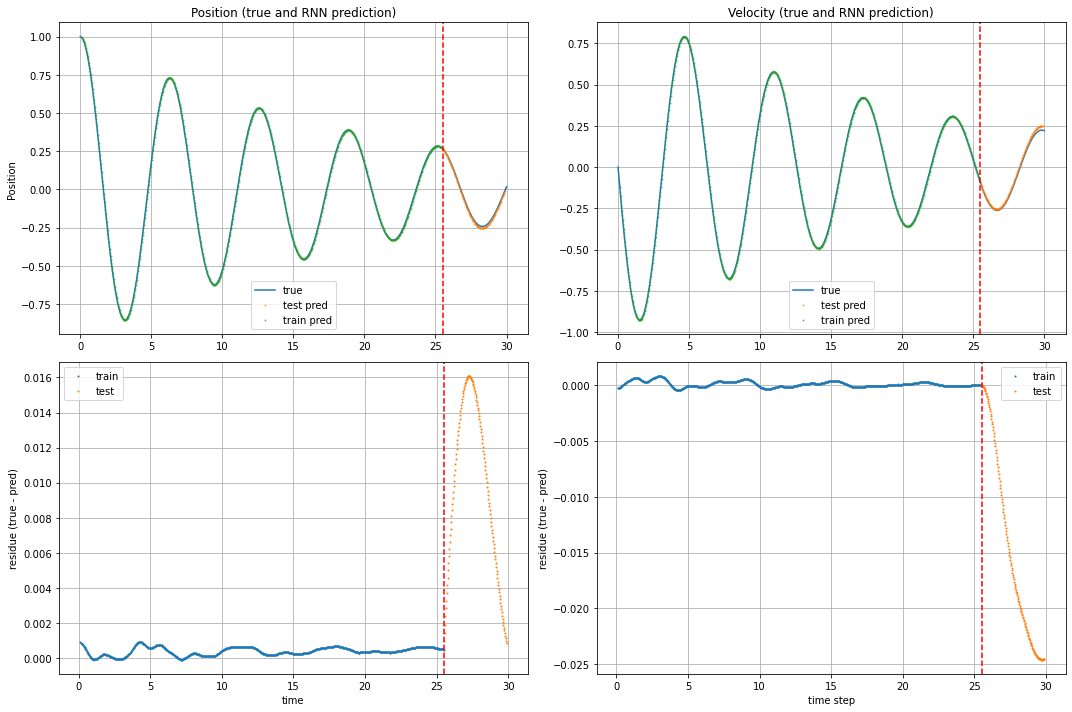

In [127]:
import matplotlib.pyplot as plt

plt.figure(figsize=(15, 10))

# Position vs Time
plt.subplot(2, 2, 1)
plt.plot(times, timeseries_p, markersize=0.5, label='true')
plt.plot(test_plot_t, test_plot_p, '.', markersize=2, label='test pred', alpha=0.6)
plt.plot(train_plot_t, train_plot_p, '.', markersize=2, label='train pred', alpha=0.6)
plt.axvline(30*0.85, linestyle='--', color='r')
plt.grid()
plt.ylabel("Position")
plt.title("Position (true and RNN prediction)")
plt.legend()

# Velocity vs Time
plt.subplot(2, 2, 2)
plt.plot(times, timeseries_v, markersize=0.5, label='true')
plt.plot(test_plot_t, test_plot_v, '.', markersize=2, label='test pred', alpha=0.6)
plt.plot(train_plot_t, train_plot_v, '.', markersize=2, label='train pred', alpha=0.6)
plt.grid()
plt.axvline(30*0.85, linestyle='--', color='r')
plt.title("Velocity (true and RNN prediction)")
plt.legend()

# Difference in Position vs Time
plt.subplot(2, 2, 3)
plt.plot(train_plot_t, -train_plot_p + train_true_p, '.', markersize=2, label='train')
plt.plot(test_plot_t,- test_plot_p + test_true_p, '.', markersize=2, label='test')
plt.grid()
plt.axvline(30*0.85, linestyle='--', color='r')
plt.xlabel("time")
plt.ylabel('residue (true - pred)')
plt.legend()

# Difference in Velocity vs Time
plt.subplot(2, 2, 4)
plt.plot(train_plot_t, -train_plot_v + train_true_v, '.', markersize=2, label='train')
plt.plot(test_plot_t, -test_plot_v  +test_true_v, '.', markersize=2, label='test')
plt.grid()
plt.axvline(30*0.85, linestyle='--', color='r')
plt.xlabel("time step")
plt.ylabel('residue (true - pred)')
plt.legend()

plt.savefig('../plot/DHOscillator_LSTM.PDF')

plt.tight_layout()
plt.show()


## Baseline model
Baseline model FFNN and PINN have the same architecture and where trained for the same amount of time and data.

In [52]:
# load the models
FFNN_baseline = torch.load('../models/DHO_FFNN_baseline.pt')
PINN_baseline = torch.load('../models/DHO_PINN_baseline.pt')

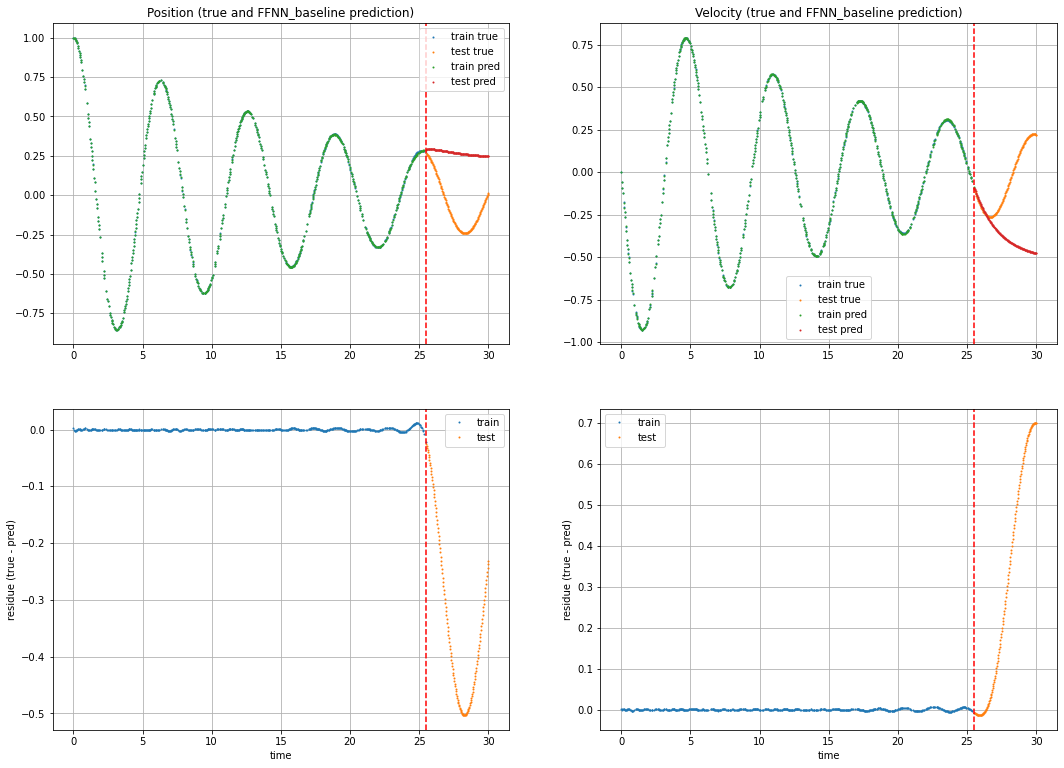

In [53]:
# plot results
plot_results(FFNN_baseline, train_X_batches, train_Y_batches, val_X, val_Y, test_X, test_Y, save=False, name='FFNN_baseline')

In [54]:
# get losses
FFNN_baseline_train_loss, FFNN_baseline_val_loss, FFNN_baseline_test_loss = get_losses(FFNN_baseline, train_X_batches, train_Y_batches, val_X, val_Y, test_X, test_Y)

Train loss: 5.001572390028741e-06
Validation loss: 6.745639893779298e-06
Test loss: 0.1473110467195511


In [55]:
# get time
FFNN_baseline_time, FFNN_baseline_time_std = get_pred_time(FFNN_baseline, test_X, n_samples=100)

Time for one prediction: 3.583685557047526e-06 +/- 3.82049346179901e-06


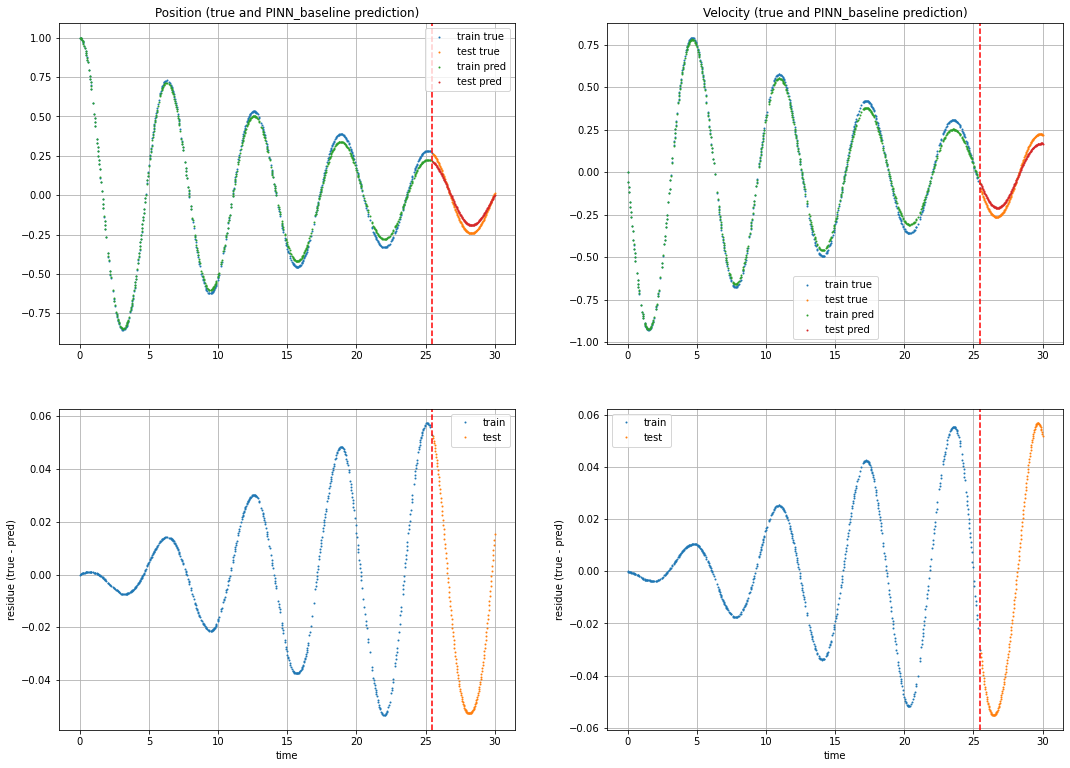

In [56]:
# plot results PINN
plot_results(PINN_baseline, train_X_batches, train_Y_batches, val_X, val_Y, test_X, test_Y, save=False, name='PINN_baseline')

In [57]:
# get losses
PINN_baseline_train_loss, PINN_baseline_val_loss, PINN_baseline_test_loss = get_losses(PINN_baseline, train_X_batches, train_Y_batches, val_X, val_Y, test_X, test_Y)

Train loss: 0.0006238690693862736
Validation loss: 0.0006585018127225339
Test loss: 0.0015676728216931224


In [58]:
# get time
PINN_baseline_time, PINN_baseline_time_std = get_pred_time(PINN_baseline, test_X, n_samples=100)

Time for one prediction: 3.3178170522054036e-06 +/- 4.715758252743587e-06


## PINN Tuned model

In [59]:
# import DHO_PINN_tuned
DHO_PINN_tuned = torch.load('../models/DHO_PINN_tuned.pt')

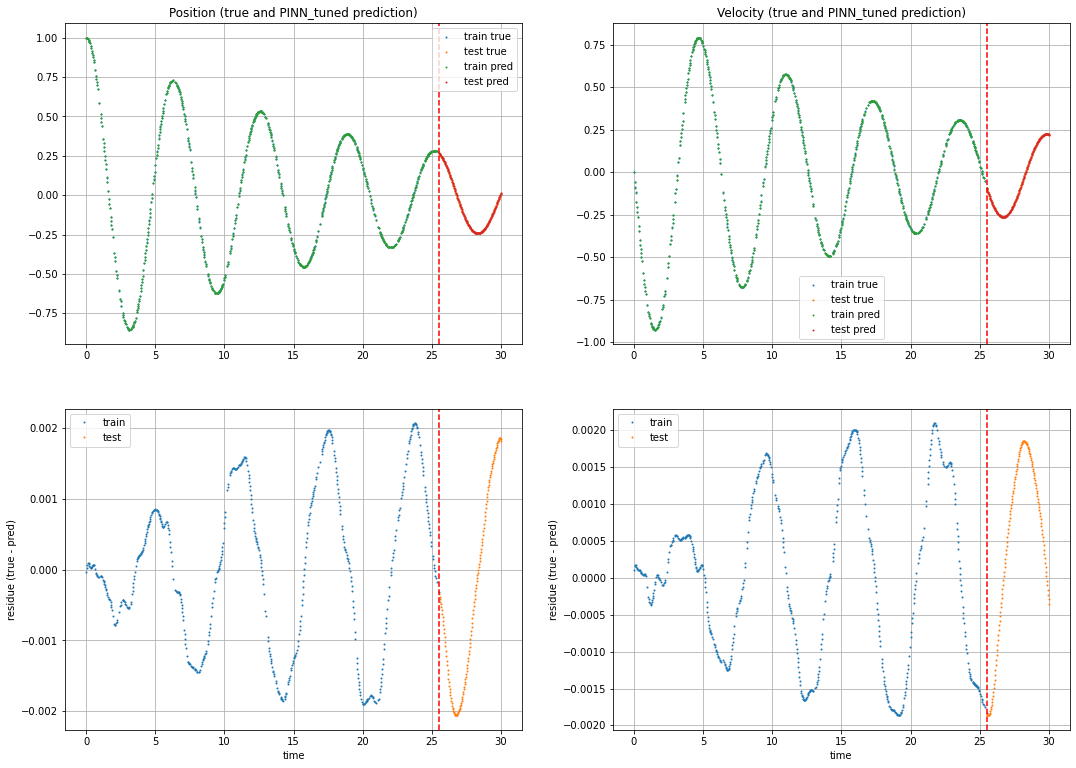

In [60]:
# plot results
plot_results(DHO_PINN_tuned, train_X_batches, train_Y_batches, val_X, val_Y, test_X, test_Y, save=True, name='PINN_tuned')

In [61]:
# get losses
DHO_PINN_tuned_train_loss, DHO_PINN_tuned_val_loss, DHO_PINN_tuned_test_loss = get_losses(DHO_PINN_tuned, train_X_batches, train_Y_batches, val_X, val_Y, test_X, test_Y)

Train loss: 1.2679423662120826e-06
Validation loss: 1.239517246176547e-06
Test loss: 1.7491795460955473e-06


In [62]:
# time
DHO_PINN_tuned_time, DHO_PINN_tuned_time_std = get_pred_time(DHO_PINN_tuned, test_X, n_samples=100)

Time for one prediction: 4.955657323201498e-06 +/- 5.464796157698012e-06


### Dataframe of configurations hyperparameters and results

In [63]:
restored_tuner = tune.Tuner.restore('/home/luigi/Documents/PHYSICS/ML/Project1/tune/DHO_PINN_tuning', objective)
restored_results = restored_tuner.get_results()

restored_df = restored_results.get_dataframe()
restored_df

NameError: name 'tune' is not defined

In [64]:
def get_alive_model(df, max_epoch):
    """
    Function to get the number of alive models at each epoch
    input: df, max_epoch
    output: alive_model
    """
    # get traininig_iteration vector
    training_iteration = df["training_iteration"]
    training_iteration = training_iteration.to_numpy()
    # alive_model = number of entries of training_iteration > epoch
    # epoch = (0, max_epoch)
    alive_model = np.zeros(max_epoch)
    for i in range(max_epoch):
        alive_model[i] = np.sum(training_iteration > i)
    return alive_model

alive_model = get_alive_model(restored_df, 50000)

NameError: name 'restored_df' is not defined

In [65]:
# show results
dfs = {result.path: result.metrics_dataframe for result in restored_results}

# twinx plot alive_model and validation loss
fig, ax1 = plt.subplots(figsize=(15, 10))
# plot the validation loss
for path, df in dfs.items():
    ax1.plot(df["training_iteration"], df["loss"], label=path)
ax1.set_yscale("log")
ax1.set_xlabel("Epoch")
ax1.set_ylabel("Validation Loss")
ax1.grid()

# plot the alive model
ax2 = ax1.twinx()
ax2.plot(alive_model, label="N model", color="black")
ax2.set_ylabel("N model")
ax2.legend()
ax2.grid()


plt.title("DHOscillator PINN tuning")
plt.grid()
# save the figure
plt.savefig('../plot/DHOscillator_PINN_tuning.png')

NameError: name 'restored_results' is not defined

## Compare with RK5

In [66]:
# get analytical solution at t = 25
t_test_start = 25
t_test_end = 30
Y_start = analytical_solution(t_test_start)
t_span = [t_test_start, t_test_end]

In [67]:
# let dt_steps = [0.1, 0.01, 0.001, 0.0001]
# for each dt_step solve the ode and get the mse for t > 25
# and the time of execution
sols = []
mses = []
exec_times = []

# linspae log scale
dt_steps = np.logspace(-2, 0.5, 5, endpoint=True)

t_span=(25,30)

for dt_step in dt_steps:
    start_time = time.time()
    sol = RK5(dumped_spring, Y_start, t_span, dt_step)
    end_time = time.time()
    exec_times.append(end_time - start_time)
    sols.append(sol)
    mse = np.mean((sol.y[0,:] - analytical_solution(sol.t)[0])**2 + (sol.y[1,:] - analytical_solution(sol.t)[1])**2)
    mses.append(mse)
    
    

c:\Users\corio\anaconda3\lib\site-packages\scipy\integrate\_ivp\common.py:39: UserWarning: The following arguments have no effect for a chosen solver: `min_step`.
  warn("The following arguments have no effect for a chosen solver: {}."


Text(0, 0.5, 'position')

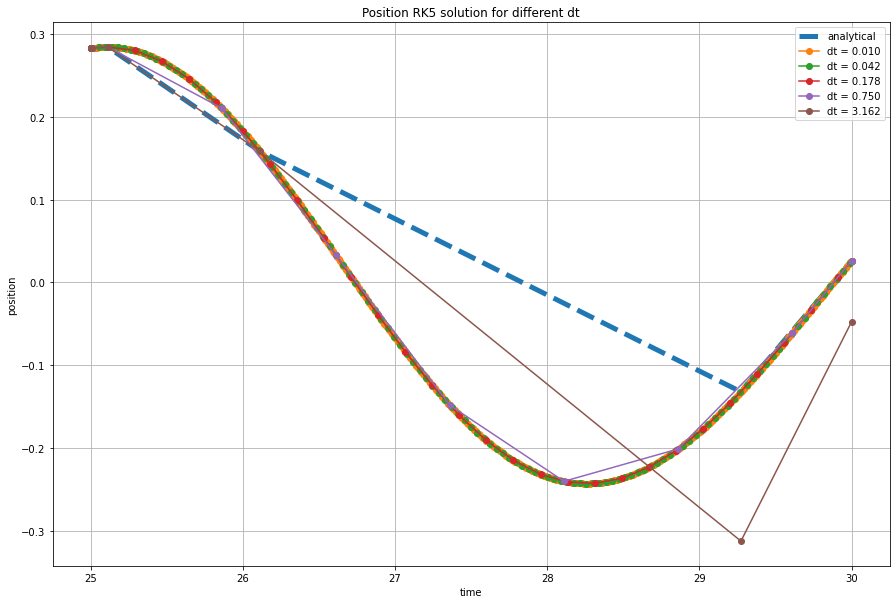

In [68]:
# plot sols
plt.figure(figsize=(15, 10))
c=0
plt.plot(sol.t, analytical_solution(sol.t)[0], label='analytical', linestyle='--', linewidth=5)

for sol in sols:
    plt.plot(sol.t, sol.y[0], label='dt = %.3f' %dt_steps[c], marker='o')
    c+=1
# add analytical solution
t = np.linspace(t_test_start, t_test_end, 1000)
# bigger linwidth
plt.grid()
plt.legend()
plt.title('Position RK5 solution for different dt')
plt.xlabel('time')
plt.ylabel('position')

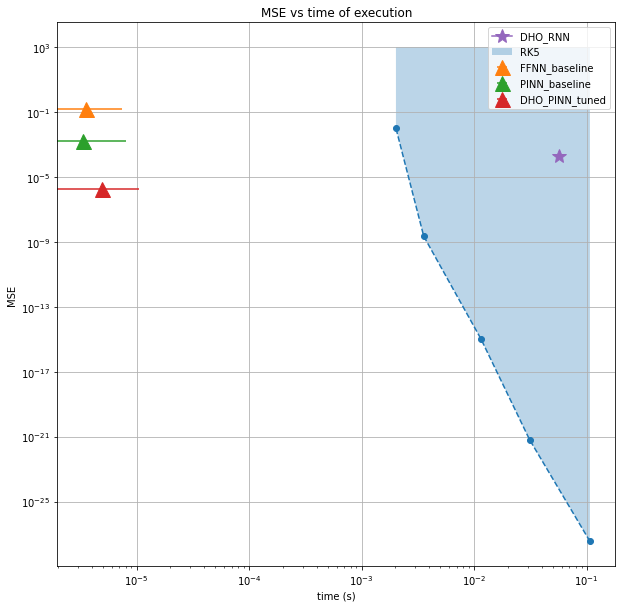

In [126]:
# plot MSE vs time of execution for RK5
plt.figure(figsize=(10, 10))
plt.plot(exec_times, mses, 'o--')
plt.fill_between(exec_times, mses, 1000, alpha=0.3, label='RK5')

# plot the execution time of the models
marker = '^'
markersize = 15
plt.errorbar([FFNN_baseline_time], [FFNN_baseline_test_loss], xerr=FFNN_baseline_time_std, fmt=marker, markersize=markersize, label='FFNN_baseline')
plt.errorbar([PINN_baseline_time], [PINN_baseline_test_loss], xerr=PINN_baseline_time_std, fmt=marker, markersize=markersize, label='PINN_baseline')
plt.errorbar([DHO_PINN_tuned_time], [DHO_PINN_tuned_test_loss], xerr=DHO_PINN_tuned_time_std, fmt=marker, markersize=markersize, label='DHO_PINN_tuned')

plt.plot([avg_execution_time_RNN], [loss_RNN], marker = '*',  markersize=markersize, label='DHO_RNN')
plt.xscale('log')
plt.yscale('log')
plt.xlabel('time (s)')
plt.ylabel('MSE')
plt.grid()
plt.legend()
plt.title('MSE vs time of execution')
#plt.xlim(7e-7, 3e-2)

# save the figure
plt.savefig('../plot/DHOscillator_MSE_vs_time.png')